# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [2]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

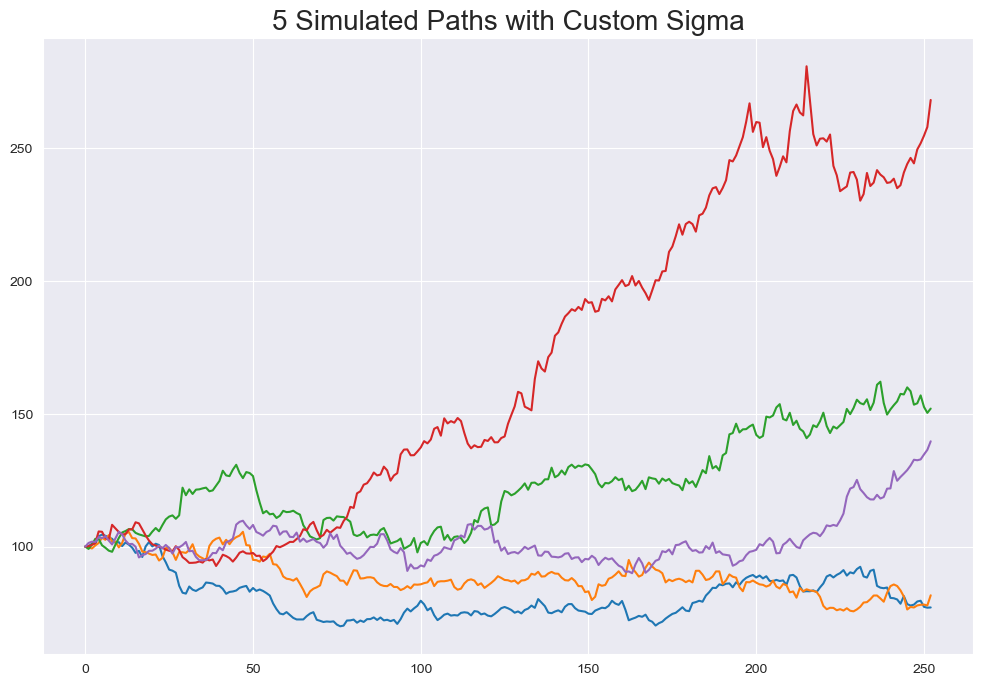

In [6]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/gd/xlvgsvz1725fp8xqfp59nr9r0000gn/T/ipykernel_21144/3352887056.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5*σ**2)*τ) / (σ*np.sqrt(τ))
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

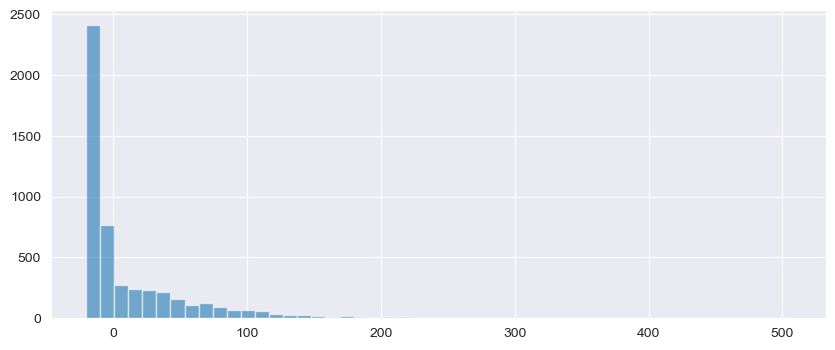

In [10]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# ————————————————————————————————————————————————————————————————————————————————
# 1) your stock‐path simulator, modified to also return the per‐step σ array
# ————————————————————————————————————————————————————————————————————————————————
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    """
    Returns:
      paths:  (n_paths, n_steps+1) array of simulated S_t
      sigma:  (n_paths, n_steps)   array of the sigma used on each increment
    """
    dt = t/n_steps
    # pick a random sigma per step
    sigma = np.random.choice([.2, .3, .45],
                             p=[.5, .3, .2],
                             size=(n_paths, n_steps))
    # generate noise
    noise = np.random.randn(n_paths, n_steps)

    # increments of the log price
    increments = (mu + r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    log_returns = np.cumsum(increments, axis=1)

    # build the paths
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths, sigma

# ————————————————————————————————————————————————————————————————————————————————
# 2) Black–Scholes delta
# ————————————————————————————————————————————————————————————————————————————————
def bs_delta(S, K, r, τ, σ):
    d1 = (np.log(S/K) + (r + 0.5*σ**2)*τ) / (σ*np.sqrt(τ))
    return norm.cdf(d1)

# ————————————————————————————————————————————————————————————————————————————————
# 3) single‐path hedging
# ————————————————————————————————————————————————————————————————————————————————
def hedge_one_path(S, sigma, K, r, T):
    """
    S:    array of length N+1
    sigma: array of length N
    """
    N = len(sigma)
    dt = T/N
    taus = np.linspace(T, 0, N+1)

    # initial delta uses sigma[0]
    Δ0 = bs_delta(S[0], K, r, taus[0], sigma[0])
    pos_const = pos_sigma = Δ0
    cash_const = cash_sigma = -Δ0 * S[0]

    for i in range(N):
        τ = taus[i+1]

        # constant-σ hedge: always use sigma[0]
        Δ_const = bs_delta(S[i+1], K, r, τ, sigma[0])

        # σ-updating hedge: realized vol up to step i+1
        log_rets = np.diff(np.log(S[:i+2]))
        σ_hat = np.std(log_rets, ddof=1) * np.sqrt(1/dt)
        Δ_sigma = bs_delta(S[i+1], K, r, τ, σ_hat)

        # rebalance constant-σ
        dpos = Δ_const - pos_const
        cash_const -= dpos * S[i+1]
        pos_const = Δ_const

        # rebalance σ-hedge
        dpos2 = Δ_sigma - pos_sigma
        cash_sigma -= dpos2 * S[i+1]
        pos_sigma = Δ_sigma

    # close at expiry
    payoff = max(S[-1] - K, 0)
    pnl_const = cash_const + pos_const*S[-1] + payoff
    pnl_sigma = cash_sigma + pos_sigma*S[-1] + payoff

    return pnl_const, pnl_sigma


# ————————————————————————————————————————————————————————————————————————————————
# 4) Monte-Carlo over many paths
# ————————————————————————————————————————————————————————————————————————————————
def run_mc(S0=100, T=1, r=0.0, mu=0.0,
           K=100, n_paths=5000, n_steps=252):
    paths, sigmas = stock_path_custom_sigma(S0, T, r, mu, n_paths, n_steps)
    pnl_const = np.zeros(n_paths)
    pnl_sigma = np.zeros(n_paths)

    for j in range(n_paths):
        pnl_const[j], pnl_sigma[j] = hedge_one_path(
            paths[j], sigmas[j], K, r, T)

    return pnl_const, pnl_sigma

# run it
p0, p1 = run_mc()

# ————————————————————————————————————————————————————————————————————————————————
# 5) plot and compare
# ————————————————————————————————————————————————————————————————————————————————
plt.figure(figsize=(10,4))
plt.hist(p0, bins=50, alpha=0.6, label='constant-σ hedge')
plt.hist(p1, bins=50, alpha=0.6, label='σ‐updating hedge')
plt.legend()
plt.title("Distribution of Hedging P&Ls ({} paths)".format(len(p0)))
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.show()

print("Constant-σ:   mean={:.4f}, std={:.4f}".format(p0.mean(), p0.std()))
print("σ‐updating:   mean={:.4f}, std={:.4f}".format(p1.mean(), p1.std()))


<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
/var/folders/gd/xlvgsvz1725fp8xqfp59nr9r0000gn/T/ipykernel_21144/2500996306.py:66: SyntaxWarning: invalid escape sequence '\s'
  axes[1].step(np.arange(len(sigma)), sigma, where='post', label="Volatility $\sigma_t$")


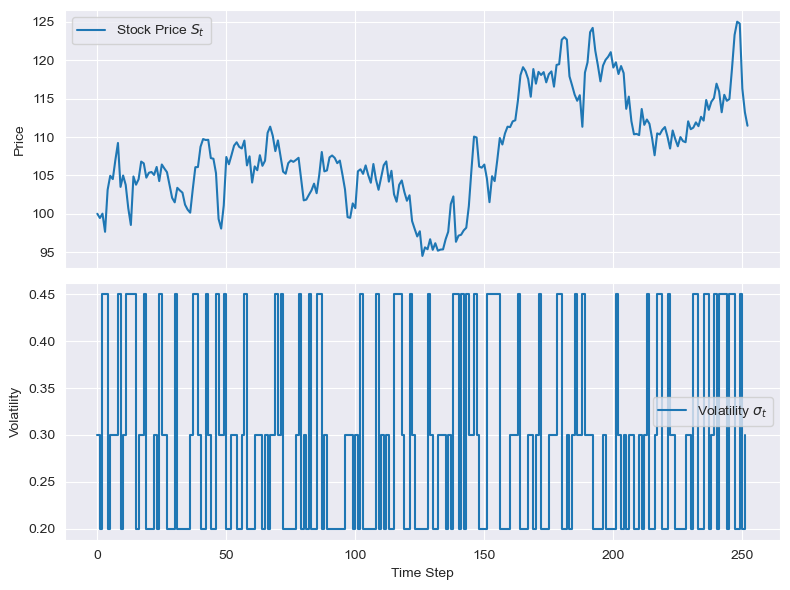

Single-path P&L (constant-σ hedge): 10.7733
Single-path P&L (σ-updating hedge):  11.2973


/var/folders/gd/xlvgsvz1725fp8xqfp59nr9r0000gn/T/ipykernel_21144/2500996306.py:66: SyntaxWarning: invalid escape sequence '\s'
  axes[1].step(np.arange(len(sigma)), sigma, where='post', label="Volatility $\sigma_t$")


NameError: name 'tools' is not defined

In [32]:

# ————————————————————————————————————————————————————————————————————————————————
# Helpers: Simulator, Delta, Hedger, Monte Carlo runner
# ————————————————————————————————————————————————————————————————————————————————
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    dt = t / n_steps
    sigma = np.random.choice([.2, .3, .45], p=[.5, .3, .2], size=(n_paths, n_steps))
    noise = np.random.randn(n_paths, n_steps)
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths, sigma

def bs_delta(S, K, r, τ, σ):
    d1 = (np.log(S / K) + (r + 0.5 * σ**2) * τ) / (σ * np.sqrt(τ))
    return norm.cdf(d1)

def hedge_one_path(S, sigma, K, r, T):
    N = len(sigma)
    dt = T / N
    taus = np.linspace(T, 0, N+1)
    sigma0 = sigma[0]
    Δ0 = bs_delta(S[0], K, r, taus[0], sigma0)
    pos_const = pos_sigma = Δ0
    cash_const = cash_sigma = -Δ0 * S[0]
    for i in range(N-1):
        τ = taus[i+1]
        Δ_const = bs_delta(S[i+1], K, r, τ, sigma0)
        log_rets = np.diff(np.log(S[:i+2]))
        σ_hat = np.std(log_rets, ddof=1) * np.sqrt(1/dt) if log_rets.size > 1 else sigma0
        Δ_sigma = bs_delta(S[i+1], K, r, τ, σ_hat)
        cash_const -= (Δ_const - pos_const) * S[i+1]
        pos_const = Δ_const
        cash_sigma -= (Δ_sigma - pos_sigma) * S[i+1]
        pos_sigma = Δ_sigma
    payoff = max(S[-1] - K, 0)
    pnl_const = cash_const + pos_const * S[-1] + payoff
    pnl_sigma = cash_sigma + pos_sigma * S[-1] + payoff
    return pnl_const, pnl_sigma

def run_mc(S0=100, T=1, r=0.0, mu=0.0, K=100, n_paths=5000, n_steps=252):
    paths, sigmas = stock_path_custom_sigma(S0, T, r, mu, n_paths, n_steps)
    pnl_const = np.zeros(n_paths)
    pnl_sigma = np.zeros(n_paths)
    for j in range(n_paths):
        pnl_const[j], pnl_sigma[j] = hedge_one_path(paths[j], sigmas[j], K, r, T)
    return pnl_const, pnl_sigma

# ————————————————————————————————————————————————————————————————————————————————
# Step 0: Single Path + Plot
# ————————————————————————————————————————————————————————————————————————————————
S_path, sigma_path = stock_path_custom_sigma(S0=100, t=1, r=0.0, mu=0.0, n_paths=1, n_steps=252)
S = S_path.flatten()
sigma = sigma_path.flatten()

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axes[0].plot(S, label="Stock Price $S_t$")
axes[0].set_ylabel("Price")
axes[0].legend()
axes[1].step(np.arange(len(sigma)), sigma, where='post', label="Volatility $\sigma_t$")
axes[1].set_ylabel("Volatility")
axes[1].set_xlabel("Time Step")
axes[1].legend()
plt.tight_layout()
plt.show()

pnl_const, pnl_sigma = hedge_one_path(S, sigma, K=100, r=0.0, T=1)
print(f"Single-path P&L (constant-σ hedge): {pnl_const:.4f}")
print(f"Single-path P&L (σ-updating hedge):  {pnl_sigma:.4f}")

# ————————————————————————————————————————————————————————————————————————————————
# Step 1: Handful of Paths (n=50) + Sample + Summary + Histogram
# ————————————————————————————————————————————————————————————————————————————————
n_test = 50
pnl_const_test, pnl_sigma_test = run_mc(n_paths=n_test, n_steps=252)

df_samples = pd.DataFrame({
    'constant_sigma_PnL': pnl_const_test,
    'sigma_updating_PnL': pnl_sigma_test
})
tools.display_dataframe_to_user(name="Sample P&Ls (first 10 paths)", dataframe=df_samples.head(10))

summary = df_samples.describe().loc[['mean', 'std']].round(4)
tools.display_dataframe_to_user(name="Summary Statistics (50 paths)", dataframe=summary)

plt.figure(figsize=(8, 4))
plt.hist(pnl_const_test, bins=15, alpha=0.6, label='constant-σ hedge')
plt.hist(pnl_sigma_test, bins=15, alpha=0.6, label='σ-updating hedge')
plt.legend()
plt.title("Histogram of P&Ls for 50 Simulated Paths")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ————————————————————————————————————————————————————————————————————————————————
# Step 2: Full Monte Carlo (n=1000) + Final Histogram + Stats
# ————————————————————————————————————————————————————————————————————————————————
n_full = 1000
p0_full, p1_full = run_mc(n_paths=n_full, n_steps=252)

plt.figure(figsize=(8, 4))
plt.hist(p0_full, bins=30, alpha=0.6, label='constant-σ hedge')
plt.hist(p1_full, bins=30, alpha=0.6, label='σ-updating hedge')
plt.legend()
plt.title(f"P&L Distribution for {n_full} Paths")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"Constant-σ hedge (n={n_full}): mean={p0_full.mean():.4f}, std={p0_full.std():.4f}")
print(f"σ-updating hedge (n={n_full}): mean={p1_full.mean():.4f}, std={p1_full.std():.4f}")
